In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

# stopwords
import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from datetime import datetime

In [20]:
# initialize the empty dataframe
df = pd.DataFrame(columns=['URL', 'Heading', 'SubHeadings', 'Content'])

In [21]:
def get_links_from_bbc_news():
    res = requests.get('https://www.bbc.com/news')

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        # Find the parent div with class 'nw-c-top-stories--international'
        top_stories_div = soup_data.find('div', class_='nw-c-top-stories--international')

        # Check if the 'nw-c-top-stories--international' div was found
        if top_stories_div:
            # Find all <a> tags within the 'top_stories_div' with a class containing 'gs-c-promo-heading'
            promo_headings = top_stories_div.find_all('a', class_=lambda x: x and 'gs-c-promo-heading' in x)

            # Extract the links from the promo_headings
            links = [heading['href'] for heading in promo_headings]

            # Return the links
            return links
        else:
            print("The 'nw-c-top-stories--international' div was not found on the page.")
    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [22]:
links = get_links_from_bbc_news()
len(links)

17

In [23]:
# drop duplicates
links = list(set(links))
links = [link for link in links if 'live' not in link]
links

['/news/world-us-canada-67359901',
 '/news/world-us-canada-67364573',
 '/news/entertainment-arts-67364587',
 '/news/world-us-canada-67339981',
 '/news/world-australia-67340904',
 '/news/world-middle-east-67364441',
 '/news/world-us-canada-67363688',
 '/news/world-europe-67365035',
 '/news/business-67364074',
 '/news/entertainment-arts-67364579',
 '/news/business-67364208',
 '/news/world-asia-67305690',
 '/news/world-middle-east-67362960']

In [25]:
# assign the links to the dataframe
df['URL'] = links
df

,URL,Heading,SubHeadings,Content
0,/news/world-us-canada-67359901,NaN,NaN,NaN
1,/news/world-us-canada-67364573,NaN,NaN,NaN
2,/news/entertainment-arts-67364587,NaN,NaN,NaN
3,/news/world-us-canada-67339981,NaN,NaN,NaN
4,/news/world-australia-67340904,NaN,NaN,NaN
5,/news/world-middle-east-67364441,NaN,NaN,NaN
6,/news/world-us-canada-67363688,NaN,NaN,NaN
7,/news/world-europe-67365035,NaN,NaN,NaN
8,/news/business-67364074,NaN,NaN,NaN
9,/news/entertainment-arts-67364579,NaN,NaN,NaN


In [26]:
MAIN_URL = 'https://www.bbc.com'

In [27]:
def requestArticle(idx, url):
    url_to_fetch = MAIN_URL + url

    # Send an HTTP GET request to the specified URL
    res = requests.get(url_to_fetch)

    # Check if the request was successful
    if res.status_code == 200:

        # df.loc[idx, 'RequestDate'] = pd.Timestamp.now()

        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        meta = soup_data.find('meta', attrs={'property': 'article:section'})

        if meta:
            # print("Topic:", meta['content'])
            df.loc[idx, 'Topic'] = meta['content']

        # Find the <article> tag and get all elements inside it
        article = soup_data.find('article')

        if article:
            # Find all elements (tags) inside the <article> tag
            article_elements = article.find_all()
            
            # Extract the heading
            heading = article.find('h1').text
            # print("Heading")
            # print(heading)

            # Extract the subheadings
            # get headlines with data-component="subheadline-block"
            subheadings = article.find_all('div', attrs={'data-component': 'subheadline-block'})
            subheadings = [subheading for subheading in subheadings if 'You may also be interested in:' not in subheading.text]
            subheadings = [subheading.text for subheading in subheadings]
            subheadings = (', ').join(subheadings)
            # print("SubHeading")
            # print(subheadings)


            # Extract the content
            content = '\n'.join([element.text for element in article_elements if element.name == 'p'])
            # print("Content")
            # print(content)

            # Update the dataframe
            df.loc[idx, 'Heading'] = heading
            df.loc[idx, 'SubHeadings'] = subheadings
            df.loc[idx, 'Content'] = content
            df.loc[idx, 'RequestDate'] = pd.Timestamp.now()
            

        else:
            print("No <article> tag found on the page.")

    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [28]:
# Loop through the links and request each article
for idx, link in enumerate(links):
    requestArticle(idx, link)

In [29]:
import os.path

# check if csv file exists
if os.path.isfile('bbc_news.csv'):
    # read the csv file
    existing_df = pd.read_csv('bbc_news.csv')
    
    # check if new URLs already exist in the csv file
    new_links = [link for link in links if not existing_df['URL'].isin([link]).any()]
    
    # append new data to the csv file
    if new_links:
        new_df = pd.DataFrame({'URL': new_links})
        df = pd.concat([existing_df, new_df], ignore_index=True)
        df.to_csv('bbc_news.csv', index=False)
else:
    # export the dataframe to csv
    df.to_csv('bbc_news.csv', index=False)

# display the dataframe
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate
0,/news/world-us-canada-67359901,Ivanka Trump testifies to New York fraud trial...,,This video can not be played\nWatch: What Ivan...,US & Canada,2023-11-09 09:46:09.697411
1,/news/world-us-canada-67364573,Third Republican debate: Four takeaways from t...,"1) Trump still looms large, 2) There was a uni...",This video can not be played\nWatch: Who Repub...,US & Canada,2023-11-09 09:46:09.781361
2,/news/entertainment-arts-67364587,Hollywood actors' union agrees tentative deal ...,"Blockbusters delayed, Stars welcome deal",US actors' union Sag-Aftra says it has agreed ...,Entertainment & Arts,2023-11-09 09:46:09.863386
3,/news/world-us-canada-67339981,Prosecutors charge 16 alleged Gambino mafia me...,,Sixteen alleged leaders and associates of the ...,US & Canada,2023-11-09 09:46:09.948010
4,/news/world-australia-67340904,Thirteen-metre wave earns Laura Enever a women...,,Australian surfer Laura Enever has set a world...,Australia,2023-11-09 09:46:10.027342
5,/news/world-middle-east-67364441,Iran-backed Yemeni rebels shoot down US drone,,Yemen's Houthi rebels have shot down a US mili...,Middle East,2023-11-09 09:46:10.095272
6,/news/world-us-canada-67363688,President Biden's son Hunter and brother James...,,Congressional Republicans have issued legal su...,US & Canada,2023-11-09 09:46:10.170206
7,/news/world-europe-67365035,âNo one can joke with usâ: Azerbaijan para...,,This video can not be played\nAzerbaijan has p...,NaN,2023-11-09 09:46:10.256597
8,/news/business-67364074,Disney boss declares new era after job cuts,,"The big problems at Disney have been fixed, th...",Business,2023-11-09 09:46:10.334902
9,/news/entertainment-arts-67364579,Woman with a Watch: Picasso masterpiece of 'go...,,A 1932 Pablo Picasso masterpiece has sold for ...,Entertainment & Arts,2023-11-09 09:46:10.402635


In [30]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens] # everything lowercase
    tokens = [word.strip() for word in tokens] # strips whitespaces
    tokens = [word for word in tokens if word.isalnum()] # only alpha numerical values
    tokens = [word for word in tokens if not word in stop_words] # removes stopwords
    return tokens 

In [31]:
df.fillna('', inplace=True)
df['Cleaned_Heading'] = df['Heading'].apply(cleanText)
df['Cleaned_SubHeadings'] = df['SubHeadings'].apply(cleanText)
df['Cleaned_Content'] = df['Content'].apply(cleanText)


In [32]:
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content
0,/news/world-us-canada-67359901,Ivanka Trump testifies to New York fraud trial...,,This video can not be played\nWatch: What Ivan...,US & Canada,2023-11-09 09:46:09.697411,"[ivanka, trump, testifies, new, york, fraud, t...",[],"[video, played, watch, ivanka, trump, stand, i..."
1,/news/world-us-canada-67364573,Third Republican debate: Four takeaways from t...,"1) Trump still looms large, 2) There was a uni...",This video can not be played\nWatch: Who Repub...,US & Canada,2023-11-09 09:46:09.781361,"[third, republican, debate, four, takeaways, m...","[1, trump, still, looms, large, 2, united, fro...","[video, played, watch, republicans, debate, wa..."
2,/news/entertainment-arts-67364587,Hollywood actors' union agrees tentative deal ...,"Blockbusters delayed, Stars welcome deal",US actors' union Sag-Aftra says it has agreed ...,Entertainment & Arts,2023-11-09 09:46:09.863386,"[hollywood, actors, union, agrees, tentative, ...","[blockbusters, delayed, stars, welcome, deal]","[us, actors, union, says, agreed, tentative, d..."
3,/news/world-us-canada-67339981,Prosecutors charge 16 alleged Gambino mafia me...,,Sixteen alleged leaders and associates of the ...,US & Canada,2023-11-09 09:46:09.948010,"[prosecutors, charge, 16, alleged, gambino, ma...",[],"[sixteen, alleged, leaders, associates, gambin..."
4,/news/world-australia-67340904,Thirteen-metre wave earns Laura Enever a women...,,Australian surfer Laura Enever has set a world...,Australia,2023-11-09 09:46:10.027342,"[wave, earns, laura, enever, women, surfing, r...",[],"[australian, surfer, laura, enever, set, world..."
5,/news/world-middle-east-67364441,Iran-backed Yemeni rebels shoot down US drone,,Yemen's Houthi rebels have shot down a US mili...,Middle East,2023-11-09 09:46:10.095272,"[yemeni, rebels, shoot, us, drone]",[],"[yemen, houthi, rebels, shot, us, military, dr..."
6,/news/world-us-canada-67363688,President Biden's son Hunter and brother James...,,Congressional Republicans have issued legal su...,US & Canada,2023-11-09 09:46:10.170206,"[president, biden, son, hunter, brother, james...",[],"[congressional, republicans, issued, legal, su..."
7,/news/world-europe-67365035,âNo one can joke with usâ: Azerbaijan para...,,This video can not be played\nAzerbaijan has p...,,2023-11-09 09:46:10.256597,"[one, joke, azerbaijan, parades, army]",[],"[video, played, azerbaijan, paraded, army, dis..."
8,/news/business-67364074,Disney boss declares new era after job cuts,,"The big problems at Disney have been fixed, th...",Business,2023-11-09 09:46:10.334902,"[disney, boss, declares, new, era, job, cuts]",[],"[big, problems, disney, fixed, boss, entertain..."
9,/news/entertainment-arts-67364579,Woman with a Watch: Picasso masterpiece of 'go...,,A 1932 Pablo Picasso masterpiece has sold for ...,Entertainment & Arts,2023-11-09 09:46:10.402635,"[woman, watch, picasso, masterpiece, muse, sells]",[],"[1932, pablo, picasso, masterpiece, sold, 139m..."


In [33]:
# join all the tokens into a single string
df['MergedText'] = df['Cleaned_Heading'] + df['Cleaned_SubHeadings'] + df['Cleaned_Content']
df['MergedText'] = df['MergedText'].apply(lambda x: ' '.join(x))

df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content,MergedText
0,/news/world-us-canada-67359901,Ivanka Trump testifies to New York fraud trial...,,This video can not be played\nWatch: What Ivan...,US & Canada,2023-11-09 09:46:09.697411,"[ivanka, trump, testifies, new, york, fraud, t...",[],"[video, played, watch, ivanka, trump, stand, i...",ivanka trump testifies new york fraud trial re...
1,/news/world-us-canada-67364573,Third Republican debate: Four takeaways from t...,"1) Trump still looms large, 2) There was a uni...",This video can not be played\nWatch: Who Repub...,US & Canada,2023-11-09 09:46:09.781361,"[third, republican, debate, four, takeaways, m...","[1, trump, still, looms, large, 2, united, fro...","[video, played, watch, republicans, debate, wa...",third republican debate four takeaways miami e...
2,/news/entertainment-arts-67364587,Hollywood actors' union agrees tentative deal ...,"Blockbusters delayed, Stars welcome deal",US actors' union Sag-Aftra says it has agreed ...,Entertainment & Arts,2023-11-09 09:46:09.863386,"[hollywood, actors, union, agrees, tentative, ...","[blockbusters, delayed, stars, welcome, deal]","[us, actors, union, says, agreed, tentative, d...",hollywood actors union agrees tentative deal e...
3,/news/world-us-canada-67339981,Prosecutors charge 16 alleged Gambino mafia me...,,Sixteen alleged leaders and associates of the ...,US & Canada,2023-11-09 09:46:09.948010,"[prosecutors, charge, 16, alleged, gambino, ma...",[],"[sixteen, alleged, leaders, associates, gambin...",prosecutors charge 16 alleged gambino mafia me...
4,/news/world-australia-67340904,Thirteen-metre wave earns Laura Enever a women...,,Australian surfer Laura Enever has set a world...,Australia,2023-11-09 09:46:10.027342,"[wave, earns, laura, enever, women, surfing, r...",[],"[australian, surfer, laura, enever, set, world...",wave earns laura enever women surfing record a...
5,/news/world-middle-east-67364441,Iran-backed Yemeni rebels shoot down US drone,,Yemen's Houthi rebels have shot down a US mili...,Middle East,2023-11-09 09:46:10.095272,"[yemeni, rebels, shoot, us, drone]",[],"[yemen, houthi, rebels, shot, us, military, dr...",yemeni rebels shoot us drone yemen houthi rebe...
6,/news/world-us-canada-67363688,President Biden's son Hunter and brother James...,,Congressional Republicans have issued legal su...,US & Canada,2023-11-09 09:46:10.170206,"[president, biden, son, hunter, brother, james...",[],"[congressional, republicans, issued, legal, su...",president biden son hunter brother james subpo...
7,/news/world-europe-67365035,âNo one can joke with usâ: Azerbaijan para...,,This video can not be played\nAzerbaijan has p...,,2023-11-09 09:46:10.256597,"[one, joke, azerbaijan, parades, army]",[],"[video, played, azerbaijan, paraded, army, dis...",one joke azerbaijan parades army video played ...
8,/news/business-67364074,Disney boss declares new era after job cuts,,"The big problems at Disney have been fixed, th...",Business,2023-11-09 09:46:10.334902,"[disney, boss, declares, new, era, job, cuts]",[],"[big, problems, disney, fixed, boss, entertain...",disney boss declares new era job cuts big prob...
9,/news/entertainment-arts-67364579,Woman with a Watch: Picasso masterpiece of 'go...,,A 1932 Pablo Picasso masterpiece has sold for ...,Entertainment & Arts,2023-11-09 09:46:10.402635,"[woman, watch, picasso, masterpiece, muse, sells]",[],"[1932, pablo, picasso, masterpiece, sold, 139m...",woman watch picasso masterpiece muse sells 193...


In [34]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [35]:
tfidf, vectorizer = TfIdfvectorGenerator(df['MergedText']) 

documents processed: 13
time spent: 0:00:00.009431


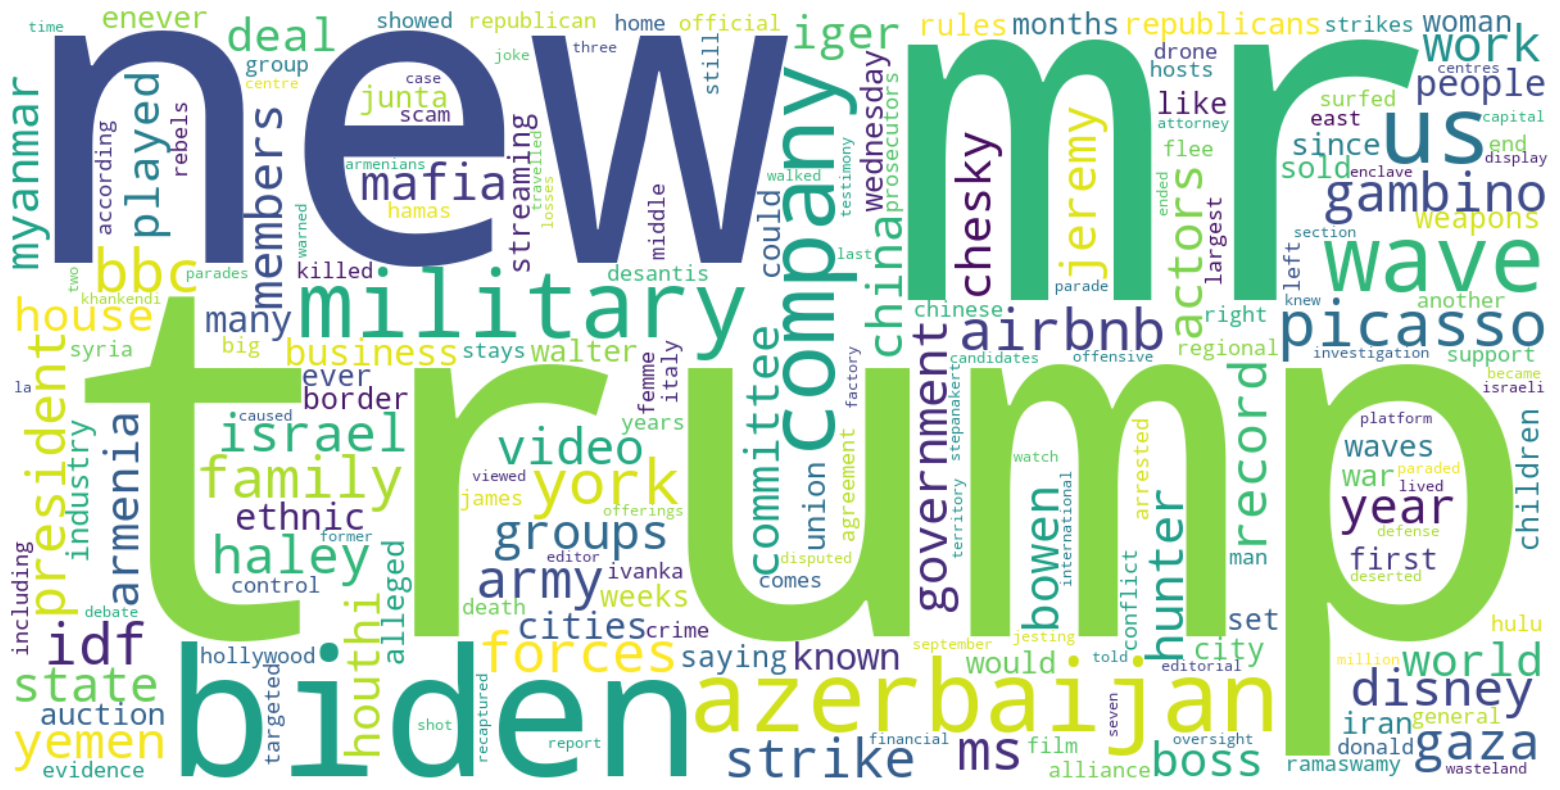

In [37]:
# Step 2: Rank words by TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word
tfidf_scores = tfidf.sum(axis=0).A1

# Create a dictionary of words and their TF-IDF scores
word_scores = dict(zip(feature_names, tfidf_scores))

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.show()
todayDate = datetime.today().strftime('%Y-%m-%d-%H%M%S')
plt.savefig('clouds/' + todayDate + '_wordcloud.png', dpi=300)

In [49]:
import smtplib
import os
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from dotenv import load_dotenv

load_dotenv()

# create message object instance
msg = MIMEMultipart()

# setup the parameters of the message
password = os.environ.get('MAIL_PASSWORD')
msg['From'] = os.environ.get('MAIL_FROM')
msg['To'] = os.environ.get('MAIL_TO')
msg['Subject'] = "Todays WordCloud to the top news of BBC"
msg['Body'] = "Todays WordCloud to the top news of BBC, see attached image"

# attach image to message body
fp = open('clouds/' + todayDate + '_wordcloud.png', 'rb')
img = MIMEImage(fp.read())
fp.close()
msg.attach(img)

# create server
server = smtplib.SMTP(os.environ.get('MAIL_HOST'))

server.starttls()

# Login Credentials for sending the mail
server.login(os.environ.get('MAIL_USER'), password)

# send the message via the server.
server.sendmail(msg['From'], msg['To'], msg.as_string())

server.quit()

print("successfully sent email to %s:" % (msg['To']))

successfully sent email to jesselang62@gmail.com:
